In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
from carps.analysis.utils import get_color_palette, setup_seaborn, savefig, get_marker_palette
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from omegaconf import OmegaConf
from tensorboard.backend.event_processing import event_accumulator


In [4]:
rundir = Path("../runsicml")

tags = [
    "rollout/ep_len_mean",
    "rollout/ep_rew_mean",
    "train/entropy_loss",
    "train/value_loss",
    "train/policy_gradient_loss",
]

def scalar_to_df(ea, tag):
    events = ea.Scalars(tag)
    return pd.DataFrame({
        "step": [e.step for e in events],
        "value": [e.value for e in events],
        "tag": tag,
    })

rundirs = [p.parent for p in rundir.glob("*/*/*/*/ppo_norm_alphanet.log")]
logs = []
for rundir in tqdm.tqdm(rundirs, total=len(rundirs), desc="Loading PPO training logs..."):
    try:
        event_file = str(next(iter(rundir.glob("tensorboard/tb_log_2/events*"))))
    except StopIteration:
        event_file = str(next(iter(rundir.glob("tensorboard/tb_log_1/events*"))))
    ea = event_accumulator.EventAccumulator(
        event_file,
        size_guidance={
            event_accumulator.SCALARS: 0,  # load all scalar events
        },
    )
    ea.Reload()
    df = pd.concat([scalar_to_df(ea, tag) for tag in tags])

    cfg = OmegaConf.load(rundir / ".hydra/config.yaml")
    df = add_metadata_to_dict(df, cfg)
    logs.append(df)
logs = pd.concat(logs).reset_index(drop=True)


Loading PPO training logs...:   0%|          | 0/60 [00:00<?, ?it/s]

Loading PPO training logs...: 100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


In [5]:
print(logs.columns)
smac_symbol = "SMAC"  #"🚂"    # "0️⃣"
default_symbol = "Def"
sawei_symbol = "SAWEI"  #"🚅"  #"1️⃣"
dim_str = ""
renaming = {
    "reward_id": {
        "symlogregret-SAWEI-P": f"symlogregret-{sawei_symbol}",
        "symlogregret-SMAC3-BlackBoxFacade": f"symlogregret-{smac_symbol}",
        "symlogregret-DefaultAction": f"symlogregret-{default_symbol}",
        "episode_finished_scaled-SAWEI-P": f"eplen-{sawei_symbol}",
        "episode_finished_scaled-SMAC3-BlackBoxFacade": f"eplen-{smac_symbol}",
        "episode_finished_scaled-DefaultAction": f"eplen-{default_symbol}",
    },
    "instance_set_id": {
        "bbob2d_fid8_3seeds": f"fid8{dim_str}",
        "bbob2d_3seeds": f"bbob{dim_str}"
    }
}
suffix = "_plot"
for key, value in renaming.items():
    logs[key + suffix] = logs[key].map(lambda x: value[x])
logs["policy_id"] = "PPO-" + logs["reward_id" + suffix] + "-" + logs["instance_set_id" + suffix]

reduce_seeds = False
if not reduce_seeds:
    logs["policy_id"] = logs["policy_id"] + "-" + logs["seed"].map(str)
print(logs["policy_id"].unique())


Index(['step', 'value', 'tag', 'seed', 'task_id', 'optimizer_id', 'reward_id',
       'instance_set_id', 'action_space_id', 'reference_performance_id',
       'objective_function', 'config'],
      dtype='object')
['PPO-symlogregret-SAWEI-fid8-5' 'PPO-symlogregret-SAWEI-fid8-3'
 'PPO-symlogregret-SAWEI-fid8-1' 'PPO-symlogregret-SAWEI-fid8-4'
 'PPO-symlogregret-SAWEI-fid8-2' 'PPO-eplen-SAWEI-bbob-5'
 'PPO-eplen-SAWEI-bbob-3' 'PPO-eplen-SAWEI-bbob-1'
 'PPO-eplen-SAWEI-bbob-4' 'PPO-eplen-SAWEI-bbob-2'
 'PPO-eplen-SAWEI-fid8-5' 'PPO-eplen-SAWEI-fid8-3'
 'PPO-eplen-SAWEI-fid8-1' 'PPO-eplen-SAWEI-fid8-4'
 'PPO-eplen-SAWEI-fid8-2' 'PPO-eplen-Def-bbob-5' 'PPO-eplen-Def-bbob-3'
 'PPO-eplen-Def-bbob-1' 'PPO-eplen-Def-bbob-4' 'PPO-eplen-Def-bbob-2'
 'PPO-symlogregret-SMAC-bbob-5' 'PPO-symlogregret-SMAC-bbob-3'
 'PPO-symlogregret-SMAC-bbob-1' 'PPO-symlogregret-SMAC-bbob-4'
 'PPO-symlogregret-SMAC-bbob-2' 'PPO-eplen-SMAC-bbob-5'
 'PPO-eplen-SMAC-bbob-3' 'PPO-eplen-SMAC-bbob-1' 'PPO-eplen-SMAC-bbob-

['rollout/ep_len_mean' 'rollout/ep_rew_mean' 'train/entropy_loss'
 'train/value_loss' 'train/policy_gradient_loss']


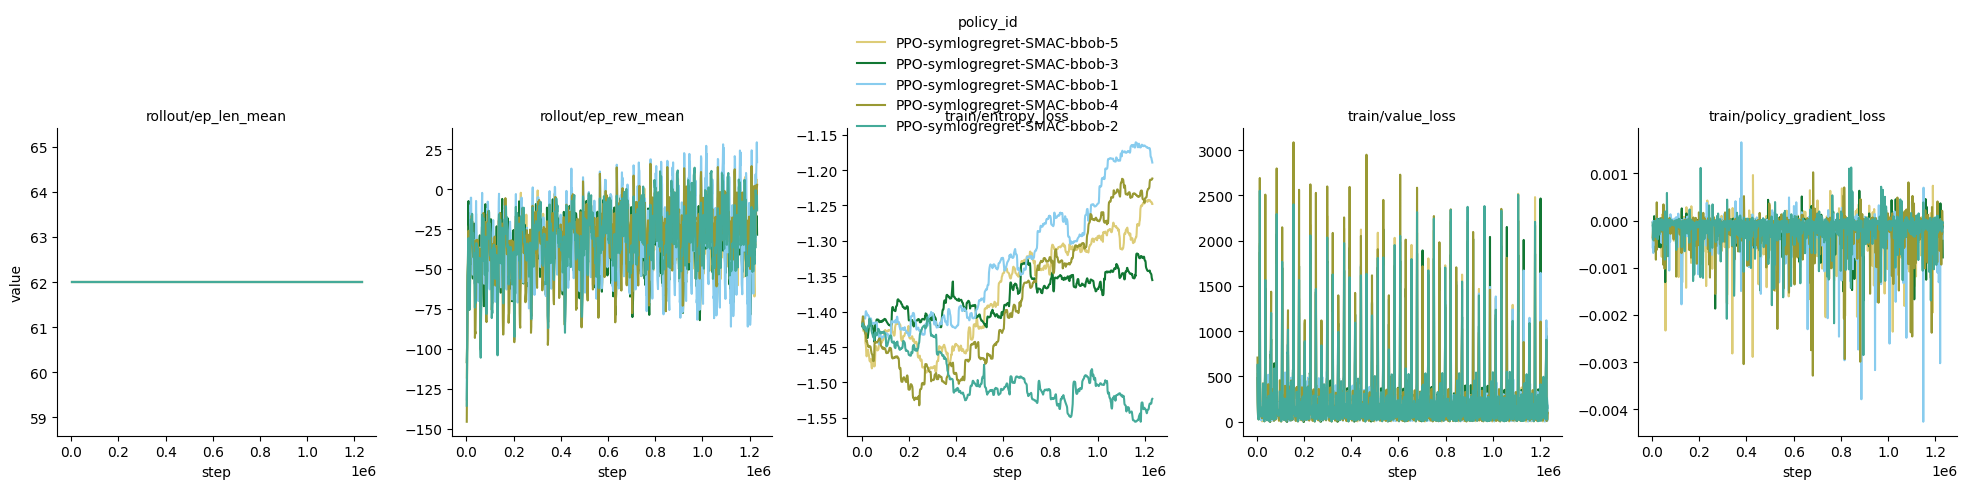

In [6]:


tags_to_plot = [
    "rollout/ep_len_mean",
    "rollout/ep_rew_mean"
]
print(logs["tag"].unique())

logs_to_plot = logs[
    # (logs["tag"].isin(tags_to_plot)) \
    # (logs["reward_id"].str.contains("ep")) \
    (logs["reward_id"].str.contains("sym")) \
    # & (logs["reward_id"].str.contains("SAWEI")) \
    & (logs["reward_id"].str.contains("SMAC")) \
    & (logs["instance_set_id"].str.contains("2d_3")) \
    # & (logs["instance_set_id"].str.contains("fid8")) \
]

hue = "policy_id"
hues = logs_to_plot[hue].unique()
palette = get_color_palette(optimizers=hues)
markers = get_marker_palette(optimizers=hues)
g = sns.FacetGrid(
    logs_to_plot,
    col="tag",
    col_wrap=max(5, len(tags_to_plot)),
    sharex=True,
    sharey=False,
    height=4,
    hue=hue,
    palette=palette
)
# g.map_dataframe(sns.lineplot, x="step", y="value")
g.map_dataframe(sns.lineplot, x="step", y="value", estimator=None, units="seed", markers=markers, markevery=100000)
g.set_titles("{col_name}")
g.add_legend(bbox_to_anchor=(0.5, 1.05))
g.tight_layout()
plt.show()

# df["value_smooth"] = (
#     df.groupby("tag")["value"]
#       .transform(lambda x: x.ewm(alpha=0.1).mean())
# )l
# plt.figure(figsize=(12, 8))
# sns.lineplot(data=df, x="step", y="value_smooth", hue="tag")
# plt.title("Smoothed Training Metrics")
# plt.tight_layout()
# plt.show()
